<a href="https://colab.research.google.com/github/arc2211/Kinect-Position-Tracking-Processing-Sketch/blob/main/site/en/hub/tutorials/action_recognition_with_tf_hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Action Recognition with an Inflated 3D CNN


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/action_recognition_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/action_recognition_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/action_recognition_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/deepmind/i3d-kinetics-400/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This Colab demonstrates recognizing actions in video data using the
[tfhub.dev/deepmind/i3d-kinetics-400/1](https://tfhub.dev/deepmind/i3d-kinetics-400/1) module. More models to detect actions in videos can be found [here](https://tfhub.dev/s?module-type=video-classification).

The original module was trained on the [kinetics-400 dateset](https://www.deepmind.com/open-source/kinetics)
and knows about 400 different actions.
Labels for these actions can be found in the
[label map file](https://github.com/deepmind/kinetics-i3d/blob/master/data/label_map.txt).

In this Colab we will use it recognize activities in videos from a UCF101 dataset.

## Setup

In [ ]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
#@title Import the necessary modules
# TensorFlow and TF-Hub modules.
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import ssl
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

In [ ]:
#@title Helper functions for the UCF101 dataset

# Utilities to fetch videos from UCF101 dataset
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
# As of July 2020, crcv.ucf.edu doesn't use a certificate accepted by the
# default Colab environment anymore.
unverified_context = ssl._create_unverified_context()

def list_ucf_videos():
  """Lists videos available in UCF101 dataset."""
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
    videos = re.findall("(v_[\w_]+\.avi)", index)
    _VIDEO_LIST = sorted(set(videos))
  return list(_VIDEO_LIST)

def fetch_ucf_video(video):
  """Fetches a video and cache into local filesystem."""
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath, context=unverified_context).read()
    open(cache_path, "wb").write(data)
  return cache_path

# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)

      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, duration=40)
  return embed.embed_file('./animation.gif')

In [ ]:
#@title Get the kinetics-400 labels
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
  labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print("Found %d labels." % len(labels))

Found 400 labels.


In [32]:
#@title Helper functions for the UCF101 dataset

# Utilities to fetch videos from UCF101 dataset
# Updated UCF_ROOT to the THUMOS14 dataset,
# which includes UCF101 videos and is currently accessible
UCF_ROOT = "https://crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
# As of July 2020, crcv.ucf.edu doesn't use a certificate accepted by the
# default Colab environment anymore.
unverified_context = ssl._create_unverified_context()

def list_ucf_videos():
  """Lists videos available in UCF101 dataset."""
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    # Using a different user agent to potentially avoid blocking
    req = request.Request(UCF_ROOT, headers={'User-Agent': 'Mozilla/5.0'})
    index = request.urlopen(req, context=unverified_context).read().decode("utf-8")
    videos = re.findall("(v_[\w_]+\.avi)", index)
    _VIDEO_LIST = sorted(set(videos))
  return list(_VIDEO_LIST)

def predict(sample_video):
  # Add a batch axis to the sample video.
  model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]

  logits = i3d(model_input)['default'][0]
  probabilities = tf.nn.softmax(logits)

  print("Top 5 actions:")
  for i in np.argsort(probabilities)[::-1][:5]:
    print(f"  {labels[i]:22}: {probabilities[i] * 100:5.2f}%")

# ... (rest of the helper functions remain the same)

# Create Your Own Video and Analyze It

In [34]:
# Create your own 15 sec video with the computer's webcam and download it

from IPython.display import HTML, Javascript, display # Fix: Import display function explicitly
from google.colab import output
from base64 import b64decode

def record_video(duration=10):
  js = Javascript('''
    async function recordVideo(duration) {
      const constraints = { video: { width: 1280, height: 720, frameRate: { ideal: 30 } } };
      const stream = await navigator.mediaDevices.getUserMedia(constraints);
      const recorder = new MediaRecorder(stream);
      const chunks = [];
      recorder.ondataavailable = e => chunks.push(e.data);
      recorder.start();

      await new Promise(resolve => setTimeout(resolve, duration * 1000));
      recorder.stop();

      await new Promise(resolve => {
        recorder.onstop = async resolve => {
          const blob = new Blob(chunks, { type: 'video/mp4' });
          const videoURL = URL.createObjectURL(blob);
          const a = document.createElement('a');
          a.href = videoURL;
          a.download = 'video.mp4';
          a.click();
          resolve();
        };
      });

      stream.getVideoTracks()[0].stop();
    }

    recordVideo(%d);
  ''' % duration)
  display(js) # Call the display function

record_video()

<IPython.core.display.Javascript object>

In [35]:
# upload your newly created video

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

video_path = list(uploaded.keys())[0] #get the name of the uploaded file

sample_video = load_video(video_path)[:200]
sample_video.shape

Saving video1.mp4 to video1 (1).mp4
User uploaded file "video1 (1).mp4" with length 1850368 bytes


(85, 224, 224, 3)


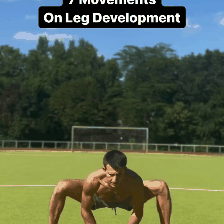

In [36]:
to_gif(sample_video)

In [37]:
predict(sample_video)

Top 5 actions:
  lunge                 : 40.39%
  squat                 : 38.48%
  push up               :  3.14%
  throwing ball         :  3.06%
  playing squash or racquetball:  2.98%
